In [1]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

# Python SQL toolkit and Object Relational Mapper
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine


In [2]:
#Reading in the original .txt file as csv

nc_voter_df = pd.read_csv('NC_Resources/history_stats_20220726.txt', delimiter='\t')
#viewing the information
nc_voter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44583 entries, 0 to 44582
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   county_desc         44583 non-null  object
 1   precinct_abbrv      44583 non-null  object
 2   vtd_abbrv           44583 non-null  object
 3   age                 44583 non-null  object
 4   party_cd            44583 non-null  object
 5   race_code           44583 non-null  object
 6   ethnic_code         44583 non-null  object
 7   sex_code            44583 non-null  object
 8   total_voters        44583 non-null  int64 
 9   election_date       44583 non-null  object
 10  stats_type          44583 non-null  object
 11  update_date         44583 non-null  object
 12  voting_method       44583 non-null  object
 13  voting_method_desc  44583 non-null  object
 14  voted_party_cd      44583 non-null  object
dtypes: int64(1), object(14)
memory usage: 5.1+ MB


In [3]:
#Beginning the cleaning process, dropping any NaN values
nc_voter_df.dropna()

,county_desc,precinct_abbrv,vtd_abbrv,age,party_cd,race_code,ethnic_code,sex_code,total_voters,election_date,stats_type,update_date,voting_method,voting_method_desc,voted_party_cd
0,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,F,4,07/26/2022,history,08/10/2022,U,ABS-CURB,DEM
1,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,F,14,07/26/2022,history,08/10/2022,V,IN-PERSON,DEM
2,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,M,6,07/26/2022,history,08/10/2022,O,ABS-1STOP,DEM
3,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,M,1,07/26/2022,history,08/10/2022,U,ABS-CURB,DEM
4,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,M,8,07/26/2022,history,08/10/2022,V,IN-PERSON,DEM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44578,MECKLENBURG,056,056,Age 41 - 65,UNA,W,NL,M,1,07/26/2022,history,08/10/2022,O,ABS-1STOP,UNA
44579,MECKLENBURG,056,056,Age Over 66,DEM,A,UN,M,1,07/26/2022,history,08/10/2022,V,IN-PERSON,DEM
44580,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,F,1,07/26/2022,history,08/10/2022,C,CURBSIDE,DEM
44581,MECKLENBURG,056,056,Age Over 66,DEM,B,NL,F,2,07/26/2022,history,08/10/2022,M,ABS-MAIL,DEM


In [4]:
#Specifying which columns to keep and eliminating ones irrelevant to our process:

nc_voter_df = nc_voter_df[['county_desc', 'party_cd', 'race_code','ethnic_code','total_voters','election_date']].copy()
nc_voter_df.head()

,county_desc,party_cd,race_code,ethnic_code,total_voters,election_date
0,MECKLENBURG,DEM,B,NL,4,07/26/2022
1,MECKLENBURG,DEM,B,NL,14,07/26/2022
2,MECKLENBURG,DEM,B,NL,6,07/26/2022
3,MECKLENBURG,DEM,B,NL,1,07/26/2022
4,MECKLENBURG,DEM,B,NL,8,07/26/2022


In [5]:
#Creating a state column and filling it with the appropriate two character shorthand:
#This column's relevancy will be evident when comparing its information with the other states to be loaded in the SQL database.
nc_voter_df['State'] ='NC'

In [6]:
#Reviewing the column names before renaming them
nc_voter_df.columns

Index(['county_desc', 'party_cd', 'race_code', 'ethnic_code', 'total_voters',
       'election_date', 'State'],
      dtype='object')

In [7]:
#Renaming the headings for increased standardization among the various datasets to be loaded into the SQL database:

new_cols = ['State','county_desc', 'party_cd', 'race_code', 'ethnic_code', 'total_voters',
       'election_date']
nc_voter_df = nc_voter_df[new_cols]

In [8]:
#Changing the names of the columns to ensure consistent naming practice across all datasets:

nc_voter_df.rename(columns = {'county_desc':'County_Name', 'party_cd':'Party',
                            'race_code':'Race_Code', 'ethnic_code': 'Ethnic_Code',
                            'total_voters':'Total_Voters',
                            'election_date':'Election_Date'}, inplace=True)

In [9]:
#checking the dtypes for quality control
nc_voter_df.dtypes

State            object
County_Name      object
Party            object
Race_Code        object
Ethnic_Code      object
Total_Voters      int64
Election_Date    object
dtype: object

In [10]:
# Change 'date' column into a 'datetime' datatype, eliminating the 'time' field as it is not used
nc_voter_df['Election_Date'] = pd.to_datetime(nc_voter_df['Election_Date'], errors='coerce')

In [11]:
#checking the dtypes to ensure changes were kept

nc_voter_df.dtypes

State                    object
County_Name              object
Party                    object
Race_Code                object
Ethnic_Code              object
Total_Voters              int64
Election_Date    datetime64[ns]
dtype: object

In [12]:
#Changing party values to ensure consistent naming practice across all datasets:

nc_voter_df['Party'] = nc_voter_df['Party'].replace(['UNA','LIB'], 'UNA')
nc_voter_df['Party'].unique()

array(['DEM', 'REP', 'UNA'], dtype=object)

In [13]:
#Running some initial inquiries and visualization strategy to understand the dataset and check for possible red flags

nc_voter_df['County_Name'].unique()

array(['MECKLENBURG', 'NASH', 'WAKE', 'CATAWBA', 'CHATHAM', 'CRAVEN',
       'CUMBERLAND', 'FRANKLIN', 'GRAHAM', 'IREDELL', 'LEE'], dtype=object)

In [14]:
voter_turnout = nc_voter_df.groupby('County_Name')['Total_Voters'].sum().sort_values(ascending=False)
voter_turnout

County_Name
MECKLENBURG    72865
WAKE           38112
CUMBERLAND     14908
CRAVEN          6138
FRANKLIN        4705
IREDELL         3181
CATAWBA         2052
LEE             1759
NASH             955
GRAHAM           871
CHATHAM          474
Name: Total_Voters, dtype: int64

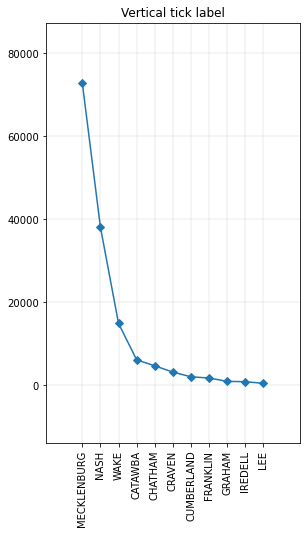

In [15]:
x = [1,2,3,4,5,6,7,8,9,10,11]
y = voter_turnout
labels = ['MECKLENBURG', 'NASH', 'WAKE', 'CATAWBA', 'CHATHAM', 'CRAVEN',
       'CUMBERLAND', 'FRANKLIN', 'GRAHAM', 'IREDELL', 'LEE']
plt.subplots_adjust(bottom=0.15)

plt.subplot(122)
plt.plot(x, y, marker='D')
plt.xticks(x, labels, rotation='vertical')
plt.margins(0.2)
plt.title("Vertical tick label")
plt.gcf().set_size_inches(10,8)
plt.grid(linewidth = 0.25)

plt.show()

In [16]:
#Path for final dataframe destination:
protocol = 'postgresql'
username = 'postgres'
password = 'postgres'
host = 'localhost'
port = 5432
database_name = 'state_voters_db'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

In [17]:
#using pandas to load converted dataframe into database
nc_voter_df.to_sql(name='nc_voter_data', con=engine, if_exists='replace', index=False)

In [18]:
#storing the dataframe in a csv for review as/if needed
nc_voter_df.to_csv('NC_Resources/cleaned_nc_voterdata.csv')

In [19]:
#Running a query to make sure our process is complete:
pd.read_sql_query('select * from nc_voter_data', con=engine).head()

,State,County_Name,Party,Race_Code,Ethnic_Code,Total_Voters,Election_Date
0,NC,MECKLENBURG,DEM,B,NL,4,2022-07-26
1,NC,MECKLENBURG,DEM,B,NL,14,2022-07-26
2,NC,MECKLENBURG,DEM,B,NL,6,2022-07-26
3,NC,MECKLENBURG,DEM,B,NL,1,2022-07-26
4,NC,MECKLENBURG,DEM,B,NL,8,2022-07-26
